<a href="https://colab.research.google.com/github/fatih260/ML-DL-Projects/blob/main/Neural_Style_Transfer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

In [11]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


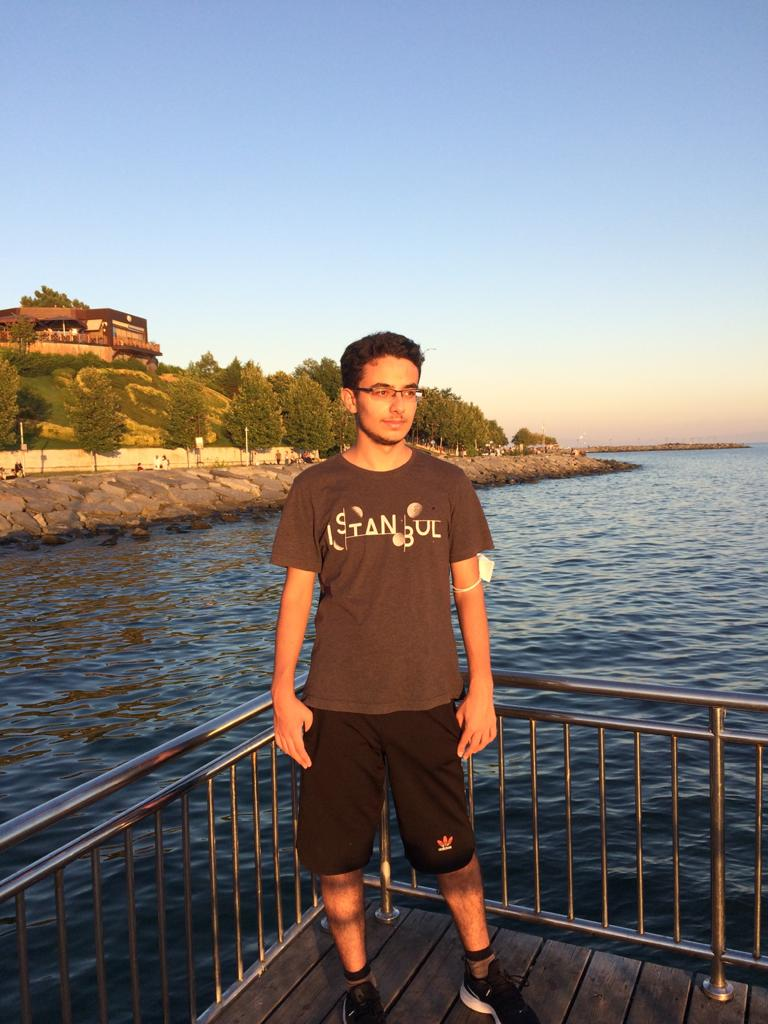

In [25]:
import requests
from io import BytesIO

# paste the image path from google drive
image_path = "/content/drive/MyDrive/test_image.jpg"
content_image = Image.open(image_path)
content_image

In [33]:
def compute_content_cost(content_output, generated_output):
    #a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    #a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    a_C = content_output[-1]
    a_G = generated_output[-1]


    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])

    # compute the cost
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)

    return J_content

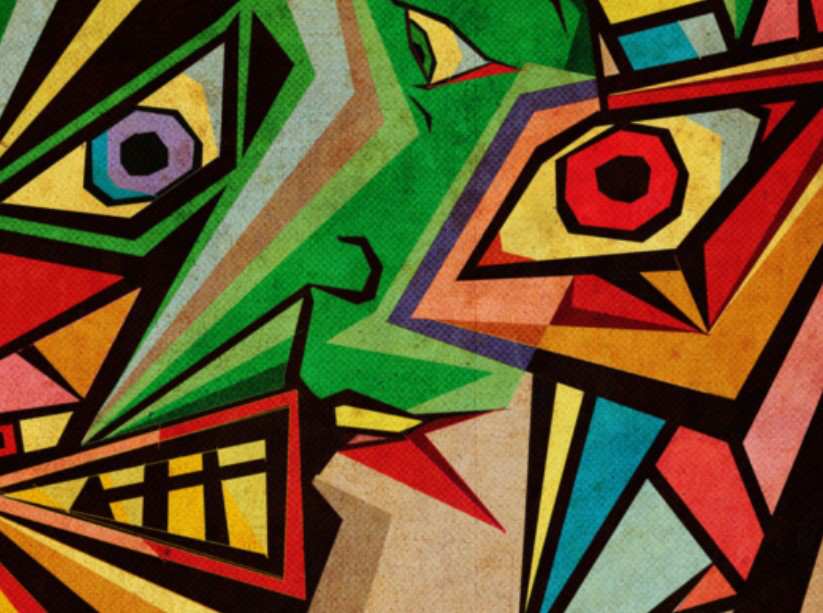

In [31]:
style_image_path = "/content/drive/MyDrive/style_image.png"
style_image = Image.open(style_image_path)
style_image

In [32]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [34]:
def compute_layer_style_cost(a_S, a_G):
    """
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))


    return J_style_layer

In [35]:
vgg.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [36]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [37]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):


    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [38]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style

    return J


(1, 400, 400, 3)


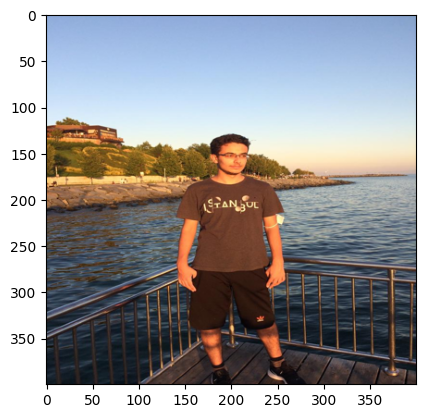

In [39]:
content_image = np.array(Image.open(image_path).resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


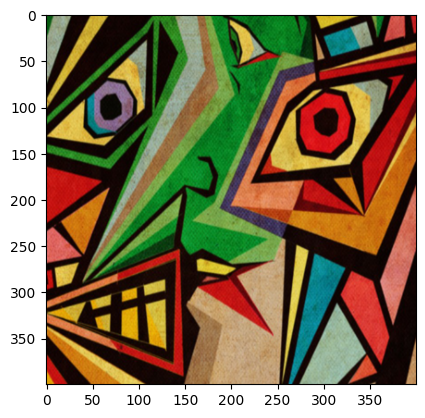

In [40]:
style_image =  np.array(Image.open(style_image_path).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


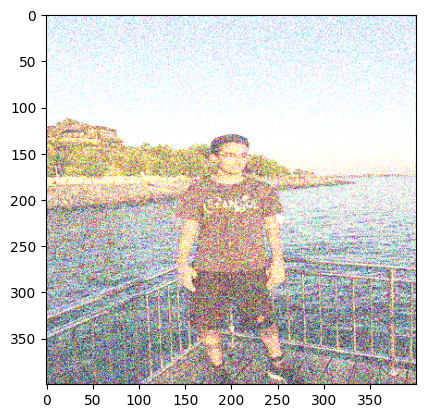

In [41]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [42]:
""" Creates a vgg model that returns a list of intermediate output values."""

def get_layer_outputs(vgg, layer_names):
    # layer_names has 'layer' elements in it.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [43]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [45]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

In [47]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2']
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.012307724, shape=(), dtype=float32)


In [48]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(6102.11, shape=(), dtype=float32)


In [49]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        # Compute a_G as the vgg_model_outputs for the current generated image

        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

Epoch 0 


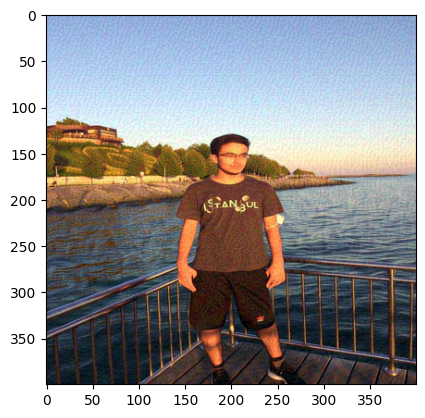

Epoch 250 


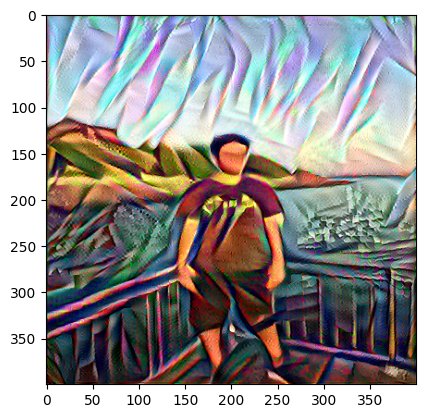

Epoch 500 


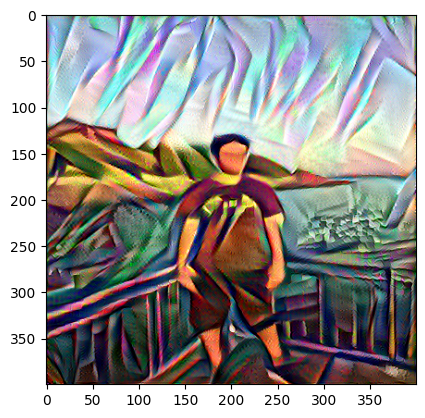

Epoch 750 


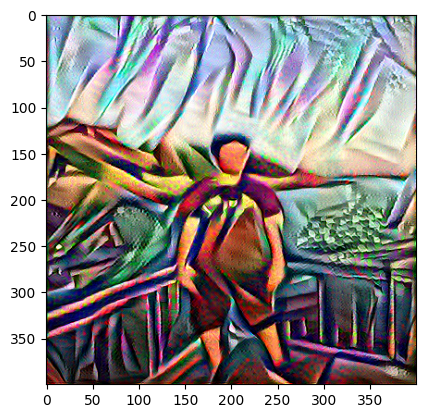

Epoch 1000 


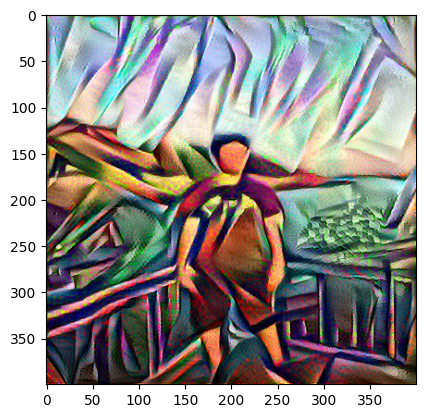

Epoch 1250 


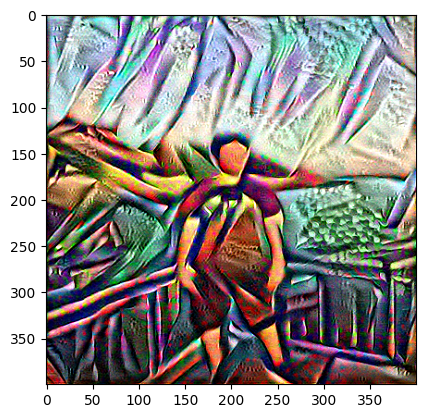

Epoch 1500 


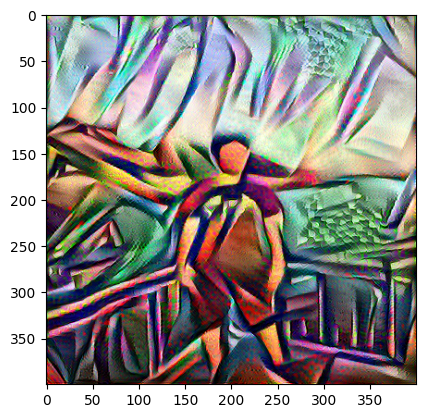

Epoch 1750 


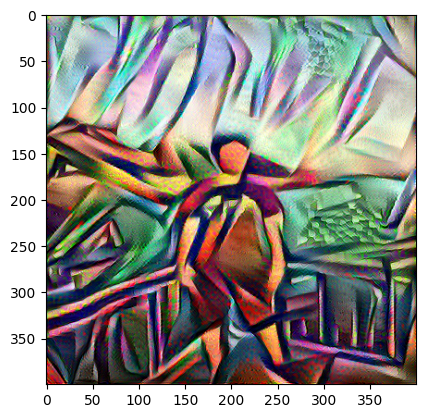

Epoch 2000 


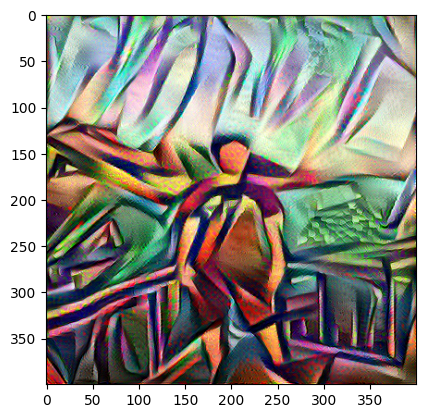

Epoch 2250 


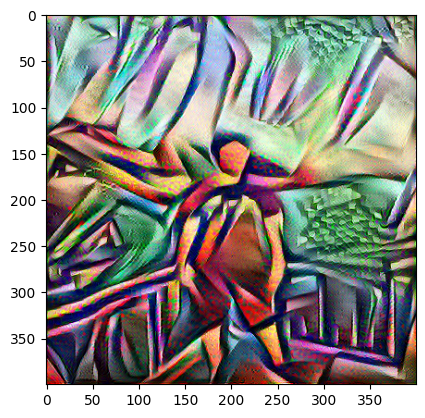

Epoch 2500 


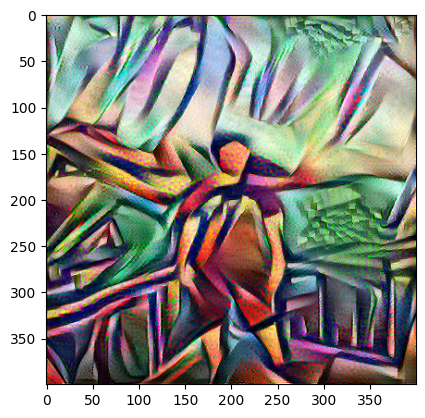

In [52]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 2501
for i in range(epochs):
    train_step(generated_image,alpha = 100, beta = 10**2)
    if i % 250 == 0:
        print(f"Epoch {i} ")

        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()